# 1. Document Your First Hunches

In [1]:
import pandas as pd

# Scenario: Investigating a sudden drop in 'Checkout Completion'
# Initial Hunch: The drop is only happening on Mobile devices.
data = {
    'device': ['Mobile', 'Desktop', 'Mobile', 'Desktop', 'Mobile', 'Tablet'],
    'completed': [False, True, False, True, False, True]
}
df = pd.DataFrame(data)
# The Hunch Log: A structured way to track intuition
hunch_log = [
    {"hunch": "Mobile conversion is failing", "target_col": "device", "expected_val": "Mobile"}
]
def audit_hunches(df, log):
    """
    Compares initial gut feelings against current data state.
    """
    print(f"--- The Hunch Audit ---")
    for item in log:
        # Calculate actual stats for the hunch
        mask = df[item['target_col']] == item['expected_val']
        conversion_rate = df[mask]['completed'].mean() * 100
        overall_rate = df['completed'].mean() * 100

        status = "VALIDATED" if conversion_rate < overall_rate else "DEBUNKED"

        print(f"Hunch: {item['hunch']}")
        print(f"Outcome: {status}")
        print(f"Segment Rate: {conversion_rate:.1f}% vs Overall: {overall_rate:.1f}%")
        print("-" * 30)
audit_hunches(df, hunch_log)

--- The Hunch Audit ---
Hunch: Mobile conversion is failing
Outcome: VALIDATED
Segment Rate: 0.0% vs Overall: 50.0%
------------------------------


# 2. Reverse-Engineer the Data Pipeline

In [2]:
import pandas as pd
import numpy as np

# Scenario: Analyzing 'Transaction Amounts' that were supposedly 'cleaned' upstream
# Problem: The upstream ETL accidentally capped values at $500 and rounded them.
raw_values = np.random.uniform(10, 600, 1000)
processed_values = np.where(raw_values > 500, 500, raw_values).round(0)
df = pd.DataFrame({'amt': processed_values})
def reverse_engineering_audit(df, col):
    """
    Detects signs of upstream 'Data Tampering' or transformation artifacts.
    """
    print(f"--- Pipeline Reverse-Engineering Audit: {col} ---")

    # 1. Detect Clipping (Capping)
    max_val = df[col].max()
    max_count = (df[col] == max_val).sum()
    max_pct = (max_count / len(df)) * 100

    if max_pct > 1: # If more than 1% of data is exactly the max value
        print(f"ALERT: Potential Capping detected. {max_pct:.1f}% of data is exactly {max_val}.")

    # 2. Detect Rounding
    non_integers = df[col].apply(lambda x: x % 1 != 0).sum()
    if non_integers == 0:
        print("ALERT: Data is 100% Integers. Was this rounded upstream? Check for loss of precision.")

    # 3. Frequency Analysis (Checking for 'Bucketized' data)
    top_value_freq = df[col].value_counts(normalize=True).iloc[0]
    if top_value_freq > 0.10:
        print(f"ALERT: High value concentration ({top_value_freq*100:.1f}%). Data may be binned or synthetic.")
reverse_engineering_audit(df, 'amt')

--- Pipeline Reverse-Engineering Audit: amt ---
ALERT: Potential Capping detected. 17.5% of data is exactly 500.0.
ALERT: Data is 100% Integers. Was this rounded upstream? Check for loss of precision.
ALERT: High value concentration (17.5%). Data may be binned or synthetic.


# 4. Map Data to Physical World Analogies

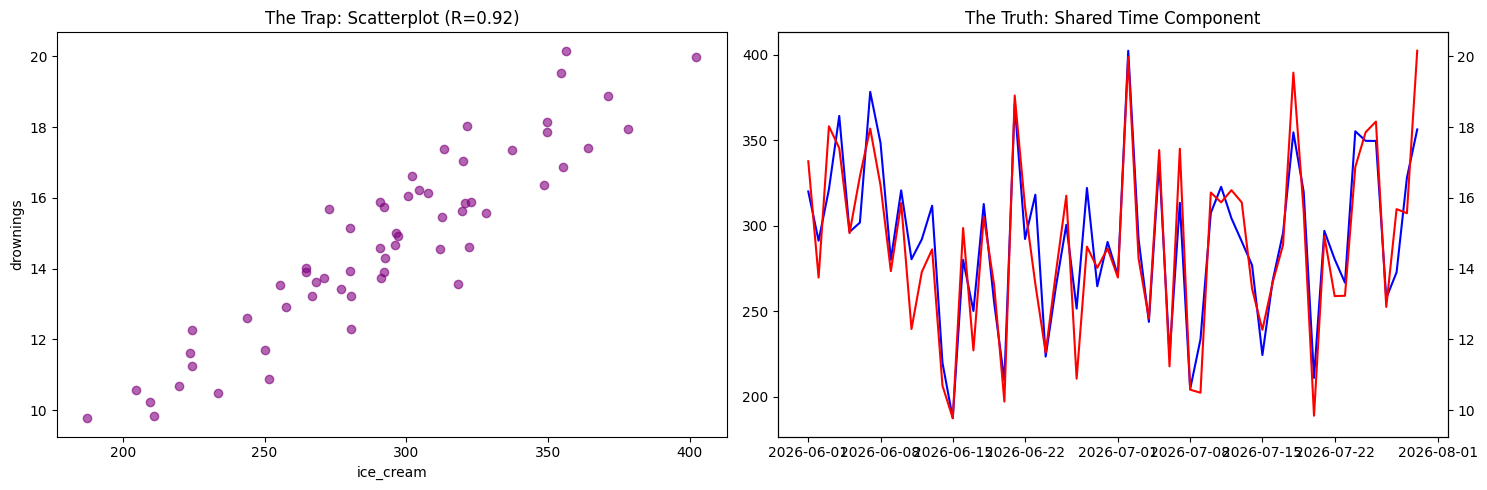

--- Ghost Correlation Audit ---
Correlation Coefficient: 0.9232


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Scenario: "Ice Cream Sales" vs "Drowning Incidents"
# Both are actually driven by "High Temperature" (the confounder)
np.random.seed(42)
days = pd.date_range(start='2026-06-01', periods=60)
temperature = np.random.normal(30, 5, 60) # High Temp = more people out
ice_cream_sales = (temperature * 10) + np.random.normal(0, 10, 60)
drowning_incidents = (temperature * 0.5) + np.random.normal(0, 1, 60)
df = pd.DataFrame({
    'date': days,
    'ice_cream': ice_cream_sales,
    'drownings': drowning_incidents
})
def ghost_correlation_audit(df, x_col, y_col):
    """
    Performs a dual-check: Scatterplot vs. Time Series Comparison.
    """
    r, p = stats.pearsonr(df[x_col], df[y_col])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 1. The Trap: Scatterplot shows high correlation
    ax1.scatter(df[x_col], df[y_col], color='purple', alpha=0.6)
    ax1.set_title(f"The Trap: Scatterplot (R={r:.2f})")
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(y_col)

    # 2. The Truth: Time Series shows the shared rhythm
    ax2.plot(df['date'], df[x_col], label=x_col, color='blue')
    ax2_twin = ax2.twinx()
    ax2_twin.plot(df['date'], df[y_col], label=y_col, color='red')
    ax2.set_title("The Truth: Shared Time Component")

    plt.tight_layout()
    plt.show()
    print(f"--- Ghost Correlation Audit ---")
    print(f"Correlation Coefficient: {r:.4f}")
    if r > 0.8:
        print("WARNING: High correlation detected. Check for 'Confounding Variables' like seasonality or system-wide events.")
ghost_correlation_audit(df, 'ice_cream', 'drownings')

# 5. Stress-Test with Synthetic Edge Cases

In [4]:
import pandas as pd
import numpy as np

# Scenario: Calculating Average Revenue Per User (ARPU)
# Base Data: Normal, well-behaved transactions
base_data = pd.DataFrame({
    'user_id': range(1, 101),
    'revenue': np.random.uniform(10, 50, 100)
})

def calculate_arpu(df):
    """Simple logic that might be vulnerable to edge cases."""
    return df['revenue'].sum() / df['user_id'].nunique()

# --- Stress Test Suite ---
def run_stress_tests(logic_func, base_df):
    results = {}

    # Test 1: The "Zero User" Problem
    empty_df = base_df.iloc[0:0]
    results['Empty Data'] = logic_func(empty_df)

    # Test 2: The "Whale" Outlier (Fat Finger)
    whale_df = base_df.copy()
    whale_df.loc[0, 'revenue'] = 1_000_000_000 # 1 Billion dollar entry
    results['Extreme Outlier'] = logic_func(whale_df)

    # Test 3: The "Duplicate ID" (Data Join Error)
    dup_df = base_df.copy()
    dup_df = pd.concat([dup_df, dup_df.iloc[[0]]]) # Duplicate one user ID
    results['Duplicate User IDs'] = logic_func(dup_df)

    print("--- Stress Test Results ---")
    for test, res in results.items():
        print(f"{test}: Result = {res}")
        if np.isinf(res) or np.isnan(res):
            print(f"FAILED: Logic broke on {test}")

run_stress_tests(calculate_arpu, base_data)

--- Stress Test Results ---
Empty Data: Result = nan
FAILED: Logic broke on Empty Data
Extreme Outlier: Result = 10000030.504559638
Duplicate User IDs: Result = 30.860754030003783


/tmp/ipython-input-2567230860.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return df['revenue'].sum() / df['user_id'].nunique()


# 6. Check for Temporal Shifts Everyone Ignores

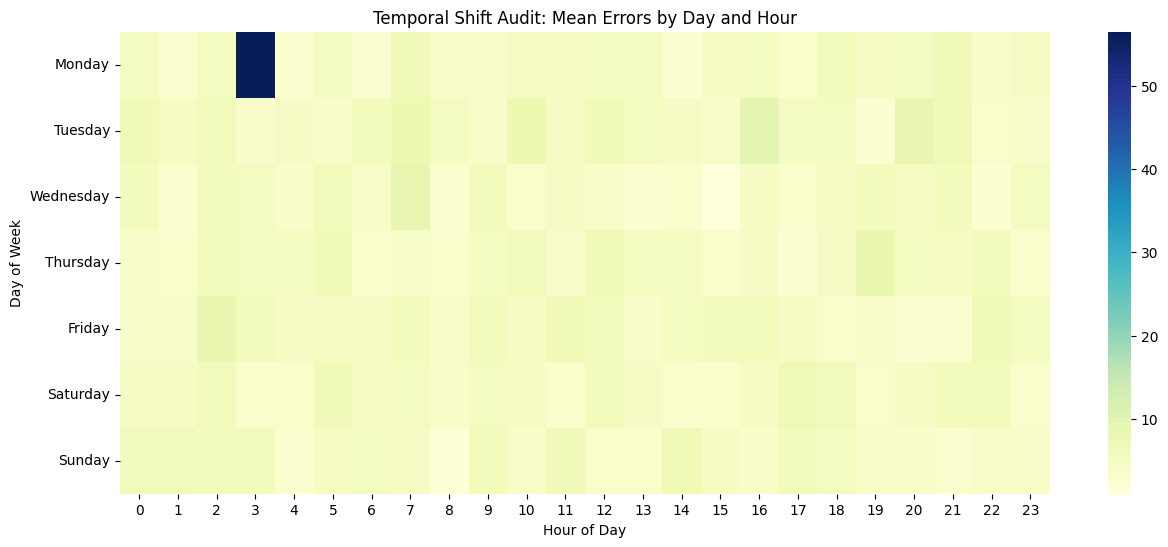

--- Temporal Insight ---
Highest error density occurs on Mondays at 3:00.
Check for scheduled tasks, batch jobs, or automated marketing triggers at this time.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scenario: Analyzing website errors over 2 weeks
# Data includes a hidden 'Temporal Shift': Errors spike every Monday at 3 AM due to a backup script
dates = pd.date_range(start="2026-01-01", periods=24*14, freq='h')
errors = np.random.poisson(5, len(dates))

# Create the "Hidden Bug": Spike on Mondays (day 0) at 3 AM
for i, dt in enumerate(dates):
    if dt.weekday() == 0 and dt.hour == 3:
        errors[i] += 50

df = pd.DataFrame({'timestamp': dates, 'error_count': errors})
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

def plot_temporal_heartbeat(df):
    """
    Creates a pivot table heatmap to expose hidden time-based patterns.
    """
    # Order days for logical flow
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    pivot = df.pivot_table(index='day_of_week', columns='hour', values='error_count', aggfunc='mean')
    pivot = pivot.reindex(days)

    plt.figure(figsize=(15, 6))
    sns.heatmap(pivot, cmap='YlGnBu', annot=False)
    plt.title("Temporal Shift Audit: Mean Errors by Day and Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.show()

    # Programmatic Insight
    max_error_period = df.groupby(['day_of_week', 'hour'])['error_count'].mean().idxmax()
    print(f"--- Temporal Insight ---")
    print(f"Highest error density occurs on {max_error_period[0]}s at {max_error_period[1]}:00.")
    print("Check for scheduled tasks, batch jobs, or automated marketing triggers at this time.")

plot_temporal_heartbeat(df)

# 7. Use the ‘5-Second Summary’ Test

In [6]:
import pandas as pd
import numpy as np

# Scenario: Analyzing conversion rates across different marketing channels
data = {
    'channel': ['Social', 'Search', 'Email', 'Referral', 'Direct'],
    'conversion_rate': [0.05, 0.048, 0.08, 0.052, 0.049],
    'spend': [1000, 1200, 300, 900, 500]
}
df = pd.DataFrame(data)
def generate_5_second_summary(df, metric_col, dimension_col):
    """
    Identifies the most significant outlier and prints a 'Headline' summary.
    """
    mean_val = df[metric_col].mean()
    # Find the dimension furthest from the mean
    df['deviation'] = (df[metric_col] - mean_val).abs()
    top_story = df.sort_values('deviation', ascending=False).iloc[0]

    diff_pct = ((top_story[metric_col] - mean_val) / mean_val) * 100
    direction = "higher" if diff_pct > 0 else "lower"

    print("--- The 5-Second Executive Summary ---")
    headline = (
        f"The {top_story[dimension_col]} channel is the primary outlier, "
        f"with a {metric_col.replace('_', ' ')} that is {abs(diff_pct):.1f}% "
        f"{direction} than the average."
    )
    print(headline)

    # Check for "The Big Risk" (High spend, low conversion)
    risk = df[(df['spend'] > df['spend'].median()) & (df[metric_col] < mean_val)]
    if not risk.empty:
        print(f"CRITICAL RISK: {risk[dimension_col].iloc[0]} has high spend but below-average conversion.")
generate_5_second_summary(df, 'conversion_rate', 'channel')

--- The 5-Second Executive Summary ---
The Email channel is the primary outlier, with a conversion rate that is 43.4% higher than the average.
CRITICAL RISK: Social has high spend but below-average conversion.


# 8. Hunt for ‘Negative Space’ (What’s Not There)


In [7]:
import pandas as pd
import numpy as np

# Scenario: Checking for missing daily logs from 5 different retail branches
# We expect a record for every branch, every day.
branches = ['North', 'South', 'East', 'West', 'Central']
dates = pd.date_range(start='2025-01-01', end='2025-01-10')

# Create the "Master Expectation" (The Negative Space Template)
expectation_index = pd.MultiIndex.from_product([dates, branches], names=['date', 'branch'])
expected_df = pd.DataFrame(index=expectation_index).reset_index()

# Actual data: 'Central' branch had a server outage from Jan 4-6 (missing rows)
actual_data = [
    {'date': '2025-01-01', 'branch': 'North', 'sales': 100},
    {'date': '2025-01-01', 'branch': 'Central', 'sales': 150},
    # ... (skipping Central branch for several days)
]
# Simulating the partial dataset
actual_df = expected_df.sample(frac=0.85, random_state=42)

def find_negative_space(actual, expected, join_cols):
    """
    Identifies records that are completely missing from the dataset.
    """
    # Perform an outer join to find rows that exist in 'expected' but not 'actual'
    missing_records = expected.merge(actual, on=join_cols, how='left', indicator=True)
    missing_records = missing_records[missing_records['_merge'] == 'left_only']

    print(f"--- Negative Space Audit ---")
    print(f"Total Expected Records: {len(expected)}")
    print(f"Actual Records Found: {len(actual)}")
    print(f"Missing 'Invisible' Records: {len(missing_records)}")

    if len(missing_records) > 0:
        print("\nTop Gaps Identified:")
        print(missing_records.groupby(join_cols[1:]).size().sort_values(ascending=False).head())

find_negative_space(actual_df, expected_df, ['date', 'branch'])

--- Negative Space Audit ---
Total Expected Records: 50
Actual Records Found: 42
Missing 'Invisible' Records: 8

Top Gaps Identified:
branch
West       3
Central    2
East       2
North      1
dtype: int64


# 9. Start with a ‘Dumb Question’ Checklist

In [8]:
import pandas as pd
import numpy as np

# Scenario: Analyzing user spending to set a 'VIP' discount threshold
# Data: 995 users spend small amounts, 5 'whales' spend massive amounts
data = {
    'user_id': range(1000),
    'spend_amt': np.concatenate([np.random.normal(50, 10, 995), [10000, 25000, 50000, 75000, 100000]])
}
df = pd.DataFrame(data)
def stress_test_metric(series):
    """
    Programmatically asks: 'Is the mean a lie?'
    """
    naive_mean = series.mean()
    median_val = series.median()
    skewness = series.skew()

    # Calculate how much the top 1% influences the total
    top_1_percent_cutoff = series.quantile(0.99)
    top_1_contribution = (series[series >= top_1_percent_cutoff].sum() / series.sum()) * 100

    print(f"--- Dumb Question Audit ---")
    print(f"Naive Average: {naive_mean:.2f}")
    print(f"Typical User (Median): {median_val:.2f}")
    print(f"Skewness Factor: {skewness:.2f}")
    print(f"Risk Alert: The top 1% of users account for {top_1_contribution:.2f}% of total value.")

    if abs(naive_mean - median_val) > median_val:
        print("CRITICAL: The mean is misleading. Production models based on 'Average Spend' will fail for 99% of users.")
stress_test_metric(df['spend_amt'])

--- Dumb Question Audit ---
Naive Average: 309.95
Typical User (Median): 50.15
Skewness Factor: 19.06
Risk Alert: The top 1% of users account for 84.01% of total value.
CRITICAL: The mean is misleading. Production models based on 'Average Spend' will fail for 99% of users.


# 10. Plot Distributions Before Cleaning

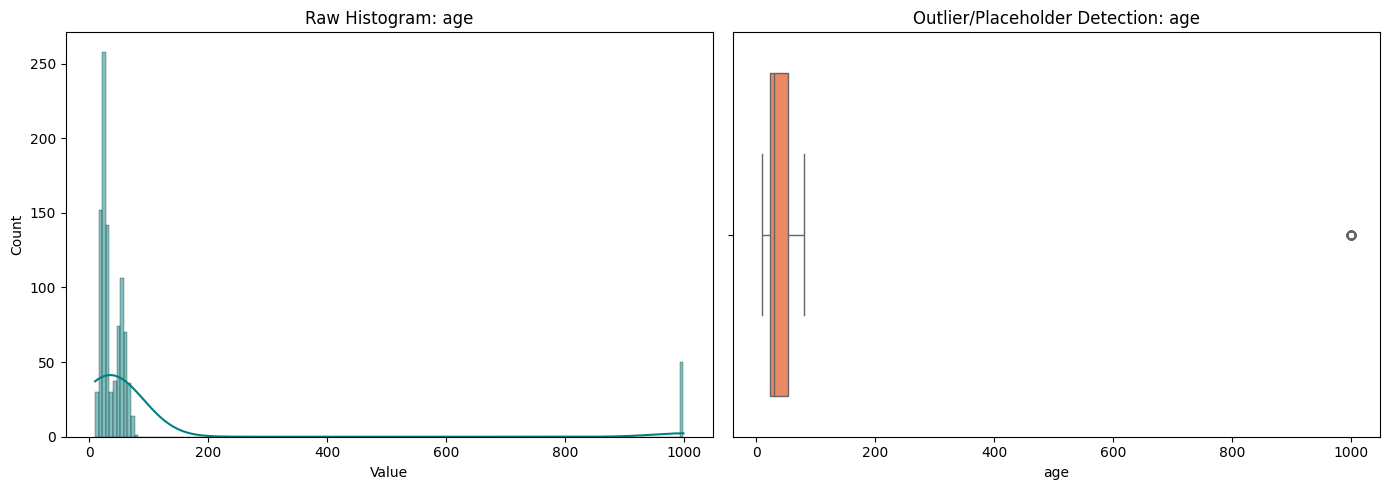

--- Distribution Insight ---
ALERT: Potential placeholder values (e.g., 999) detected.
Mean: 84.25
Median: 30.20


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scenario: Analyzing 'Purchase Age' from a raw database export
# Data contains: Real ages, '999' as a placeholder, and a mix of two regions (bimodal)
raw_data = np.concatenate([
    np.random.normal(25, 5, 600),   # Segment A: Younger users
    np.random.normal(55, 8, 350),   # Segment B: Older users
    [999] * 50                      # Technical placeholder: 5% of data
])
df = pd.DataFrame({'age': raw_data})

def raw_distribution_audit(df, column):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # 1. Histogram with KDE to find Bimodal shapes
    sns.histplot(df[column], kde=True, ax=ax1, color='teal')
    ax1.set_title(f"Raw Histogram: {column}")
    ax1.set_xlabel("Value")

    # 2. Boxplot to identify extreme "Magic Number" placeholders
    sns.boxplot(x=df[column], ax=ax2, color='coral')
    ax2.set_title(f"Outlier/Placeholder Detection: {column}")

    plt.tight_layout()
    plt.show()

    # Programmatic Check for Bimodal Distribution
    # (Simplified: check if mean is far from the peak)
    print("--- Distribution Insight ---")
    if df[column].max() > 500: # Threshold for common 999 placeholders
        print("ALERT: Potential placeholder values (e.g., 999) detected.")

    print(f"Mean: {df[column].mean():.2f}")
    print(f"Median: {df[column].median():.2f}")

raw_distribution_audit(df, 'age')